In [111]:
from dotenv import load_dotenv
import getpass
import os
load_dotenv()


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")



In [112]:
#This code implements a tree search algorithm where each node represents a step in a decision-making process.
#  Reflections (evaluations) of each node help determine whether a solution has been found, 
# and backpropagation ensures that the success of a node propagates up to its ancestors. 
# The upper_confidence_bound method helps balance exploration and exploitation during the search.


import math
from collections import deque
from typing import Optional

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    reflections: str = Field(
        description="The critique and reflections on the sufficiency, superfluency,"
        " and general quality of the response"
    )
    score: int = Field(
        description="Score from 0-10 on the quality of the candidate response.",
        gte=0,
        lte=10,
    )
    found_solution: bool = Field(
        description="Whether the response has fully solved the question or task."
    )

    def as_message(self):
        return HumanMessage(
            content=f"Reasoning: {self.reflections}\nScore: {self.score}"
        )

    @property
    def normalized_score(self) -> float:
        return self.score / 10.0

class Node:
    def __init__(
        self,
        messages: list[BaseMessage],
        reflection: Reflection,
        parent: Optional["Node"] = None,
    ):
        self.messages = messages
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f""
        )

    @property
    def is_solved(self):
        """If any solutions exist, we can end the search."""
        return self._is_solved

    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child_score(self):
        """Return the child with the highest value."""
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        """Check for how far we've rolled out the tree."""
        if self.children:
            return 1 + max([child.height for child in self.children])
        return 1

    def upper_confidence_bound(self, exploration_weight=1.0):
        """Return the UCT score. This helps balance exploration vs. exploitation of a branch."""
        if self.parent is None:
            raise ValueError("Cannot obtain UCT from root node")
        if self.visits == 0:
            return self.value
        # Encourages exploitation of high-value trajectories
        average_reward = self.value / self.visits
        # Encourages exploration of less-visited trajectories
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)

        print(average_reward + exploration_weight * exploration_term)
        return average_reward + exploration_weight * exploration_term

    def backpropagate(self, reward: float):
        """Update the score of this node and its parents."""
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            #printing the value 
            print(f"Backpropagating. Node value: {node.value}, visits: {node.visits}")
            node = node.parent

    def get_messages(self, include_reflections: bool = True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]
        return self.messages

    def get_trajectory(self, include_reflections: bool = True) -> list[BaseMessage]:
        """Get messages representing this search branch."""
        messages = []
        node = self
        while node:
            messages.extend(
                node.get_messages(include_reflections=include_reflections)[::-1]
            )
            node = node.parent
        # Reverse the final back-tracked trajectory to return in the correct order
        return messages[::-1]  # root solution, reflection, child 1, ...
        print(f"Trajectory: {messages}")

    def _get_all_children(self):
        all_nodes = []
        nodes = deque()
        nodes.append(self)
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            for n in node.children:
                nodes.append(n)
        return all_nodes

    def get_best_solution(self):
        """Return the best solution from within the current sub-tree."""
        all_nodes = [self] + self._get_all_children()
        best_node = max(
            all_nodes,
            # We filter out all non-terminal, non-solution trajectories
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,

        )

        print(best_node)
        return best_node

    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent

In [113]:
from typing_extensions import TypedDict


class TreeState(TypedDict):
    # The full tree
    root: Node
    # The original input
    input: str

In [114]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4")

from langchain_groq import ChatGroq

llm = ChatGroq(model="mixtral-8x7b-32768")

In [115]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_node = ToolNode(tools=tools)

In [116]:
#reflection chain will score agent outputs based on the decision 

from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Reflect and grade the assistant response to the user question below.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="candidate"),
    ]
)

reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice="Reflection").with_config(
        run_name="Reflection"
    )
    | PydanticToolsParser(tools=[Reflection])
)


@as_runnable
def reflection_chain(inputs) -> Reflection:
    tool_choices = reflection_llm_chain.invoke(inputs)
    reflection = tool_choices[0]
    if not isinstance(inputs["candidate"][-1], AIMessage):
        reflection.found_solution = False
    return reflection

In [117]:
from langchain_core.prompt_values import ChatPromptValue
from langchain_core.runnables import RunnableConfig

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


initial_answer_chain = prompt_template | llm.bind_tools(tools=tools).with_config(
    run_name="GenerateInitialCandidate"
)


parser = JsonOutputToolsParser(return_id=True)

In [118]:
initial_response = initial_answer_chain.invoke(
    {"input": "Write a research report on lithium pollution."}
)
initial_response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_19j7', 'function': {'arguments': '{"query":"lithium pollution impacts"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 461, 'prompt_tokens': 1226, 'total_tokens': 1687, 'completion_time': 0.751391427, 'prompt_time': 0.067593167, 'queue_time': 0.0011302519999999983, 'total_time': 0.818984594}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-40a47e6a-4838-4787-b9c6-758fd34f73b6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'lithium pollution impacts'}, 'id': 'call_19j7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1226, 'output_tokens': 461, 'total_tokens': 1687})

In [119]:

# Define the node we will add to the graph
def generate_initial_response(state: TreeState) -> dict:
    """Generate the initial candidate response."""
    res = initial_answer_chain.invoke({"input": state["input"]})
    parsed = parser.invoke(res)
    tool_responses = [tool_node.invoke(
        {"messages": [
            AIMessage(content="",tool_calls=[{"name":r["type"], "args":r["args"], 'id':r['id']}]) 
        ]}
    ) for r in parsed]
    output_messages = [res] + [tr['messages'][0] for tr in tool_responses]
    reflection = reflection_chain.invoke(
        {"input": state["input"], "candidate": output_messages}
    )
    root = Node(output_messages, reflection=reflection)
    return {
        **state,
        "root": root,
    }

In [120]:
# This generates N candidate values
# for a single input to sample actions from the environment


def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config["configurable"].get("N", 5)
    bound_kwargs = llm.bind_tools(tools=tools).kwargs
    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config["callbacks"],
        run_name="GenerateCandidates",
        **bound_kwargs,
    )
    return [gen.message for gen in chat_result.generations[0]]


expansion_chain = prompt_template | generate_candidates

In [121]:
res = expansion_chain.invoke({"input": "Write a research report on lithium pollution."})
res

BadRequestError: Error code: 400 - {'error': {'message': "'n' : number must be at most 1", 'type': 'invalid_request_error'}}

In [90]:
#Reflect: score the action based on the tool response.
#Initial response: to create the root node and start the search.
#Expand: generate 5 candidate "next steps" from the best spot in the current tree


from collections import defaultdict

def select(root: Node) -> dict:
    """Starting from the root node a child node is selected at each tree level until a leaf node is reached."""

    if not root.children:
        return root
    
    node = root
    while node.children:
        max_child = max(node.children, key=lambda child: child.upper_confidence_bound())
        node = max_child

    return node

def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree, generate N candidates for the next step."""
    root = state["root"]
    best_candidate: Node = select(root)
    messages = best_candidate.get_trajectory()
    # Generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke(
        {"input": state["input"], "messages": messages}, config
    )
    parsed = parser.batch(new_candidates)
    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]
    tool_responses = [(i,tool_node.invoke(
        {"messages":
            [AIMessage(content="",tool_calls=[{"name":tool_call["type"], "args":tool_call["args"], 'id':tool_call['id']}])]
        }
    )) for i, tool_call in flattened]
    collected_responses = defaultdict(list)
    for i, resp in tool_responses:
        collected_responses[i].append(
            resp['messages'][0]
        )
    output_messages = []
    for i, candidate in enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])

    # Reflect on each candidate
    # For tasks with external validation, you'd add that here.
    reflections = reflection_chain.batch(
        [{"input": state["input"], "candidate": msges} for msges in output_messages],
        config,
    )
    # Grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]
    best_candidate.children.extend(child_nodes)
    # We have already extended the tree directly, so we just return the state
    return state

In [68]:
from typing import Literal

from langgraph.graph import END, StateGraph, START


def should_loop(state: TreeState) -> Literal["expand", "__end__"]:
    """Determine whether to continue the tree search."""
    root = state["root"]
    if root.is_solved:
        return END
    if root.height > 5:
        return END
    return "expand"


builder = StateGraph(TreeState)
builder.add_node("start", generate_initial_response)
builder.add_node("expand", expand)
builder.add_edge(START, "start")


builder.add_conditional_edges(
    "start",
    # Either expand/rollout or finish
    should_loop,
)
builder.add_conditional_edges(
    "expand",
    # Either continue to rollout or finish
    should_loop,
)

graph = builder.compile()

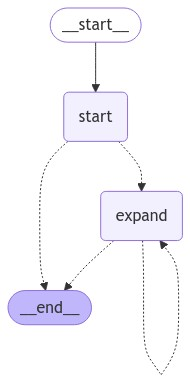

In [92]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [95]:
question = "Generate a table with the average size and weight, as well as the oldest recorded instance for each of the top 5 most common birds."
last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'Based on the information provided by the tool, I will now reflect on the assistant\'s response and grade it.\n\nReflection:\nThe assistant provided a table with the average size and weight, as well as the oldest recorded instance for each of the top 5 most common birds.\n\nTo generate the table, the assistant used a tool to gather information about the top 5 most common birds. The tool returned content from various sources, and the assistant extracted the necessary details and organized them into a table.\n\nGrade: A-\nThe assistant\'s response is mostly correct and provides valuable information. However, the response could have been more concise and clear. Additionally, the table format was not provided, which may make it difficult for the user to read the information.\n\nHere\'s a suggested format for the table:\n\n| Bird species     | Average size (inches) | Average weight (ounces) | Oldest recorded instance (years) |\n|------------------|----------------------|-----------------------|---------------------------------|\n| American Goldfinch|                     |                       | 10 years and 5 months           |\n| Downy Woodpecker |                     |                       | up to 10                         |\n| Common Grackle  | 5.6                  | 1.1                   | almost 23                         |\n| Northern Cardinal|                     |                       | N/A                              |\n| Mourning Dove    | 11.4                 | 4.9                   | N/A                              |\n\nNote: I assumed the "average size" referred to the wingspan in inches and "average weight" referred to the weight in ounces. However, I couldn\'t find specific values for the American Goldfinch, Downy Woodpecker, and Northern Cardinal. Therefore, I left those fields blank. Additionally, I didn\'t find any information about the Mourning Dove, but I included it for completeness.'}}

In [96]:
question = "Write out magnus carlson series of moves in his game against Alireza Firouzja and propose an alternate strategy"
last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': "Based on the provided information, I will now reflect on the response and grade it according to the given criteria.\n\nReflections:\n- The tool_call provided a series of games between Magnus Carlsen and Alireza Firouzja, including their most recent match in the Chess.com Classic 2024.\n- Firouzja beat Carlsen in both the Grand Final and Reset matches, demonstrating his strong performance in speed chess.\n- Carlsen has been the world champion for several years, but Firouzja has made a significant impact in the chess world at a very young age.\n- Firouzja has been hailed as the greatest talent of the next generation, and he has already defeated Carlsen multiple times in various tournaments.\n\nGrade:\n- Found solution: Yes, a clear solution has been provided by analyzing the results of the matches between Carlsen and Firouzja.\n- Reflections: I have critically reflected upon the sufficiency and general quality of the assistant's response, highlighting the important points from the provided information.\n- Score: 9 out of 10. The response is comprehensive and informative, providing a clear overview of the matches and the players' performance. However, it could have been improved by offering more specific insights or a detailed analysis of the games.\n\nAlternate strategy:\nConsidering the given context, an alternate strategy for Magnus Carlsen could be to thoroughly prepare for speed chess tournaments and focus on his opening moves against Alireza Firouzja. Since Firouzja has already proven to be a formidable opponent in these circumstances, Carlsen should aim to gain an advantage early in the game, capitalizing on his experience and deep understanding of the game. Additionally, Carlsen could study Firouzja's playing style and identify potential weaknesses or patterns that could be exploited in their future matches."}}

In [93]:
solution_node = last_step["expand"]["root"].get_best_solution()
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

TypeError: 'NoneType' object is not subscriptable

In [123]:


# D vacation options
beach_vacation = "a relaxing Beach vacation"
mountain_vacation = "a Mountain hiking adventure"
city_vacation = "an exciting City exploration"
countryside_vacation = "a peaceful Countryside retreat"

#  first question
print("Do you prefer a relaxing or active vacation?")
first_answer = input("Type 'relaxing' or 'active': ").lower()

if first_answer == "relaxing":
    # 2nd quest about beach or mountains
    print("Do you prefer the beach or the mountains?")
    second_answer = input("Type 'beach' or 'mountains': ").lower()
    
    if second_answer == "beach":
        recommendation = beach_vacation
    elif second_answer == "mountains":
        recommendation = mountain_vacation
    else:
        recommendation = "Sorry, I didn't understand your choice."

elif first_answer == "active":
    # 3rd quest city or countryside
    print("Do you prefer the city or the countryside?")
    second_answer = input("Type 'city' or 'countryside': ").lower()
    
    if second_answer == "city":
        recommendation = city_vacation
    elif second_answer == "countryside":
        recommendation = countryside_vacation
    else:
        recommendation = "Sory, I didn't understand your choice."

else:
    recommendation = "Sorry, I didn't understand your choice."

#  final recommendation
print(f"\nBased on your choices, we recommend: {recommendation}")

# Print a summary of all choices
print("\nYour choices:")
print(f"1. {first_answer}")
print(f"2. {second_answer}")

Do you prefer a relaxing or active vacation?
Do you prefer the city or the countryside?

Based on your choices, we recommend: an exciting City exploration

Your choices:
1. active
2. city


###Project ->  Vacation Recommendation


In [122]:
class Node:
    def __init__(self, question):
        # Initialize a node with a question and an empty dictionary for children
        self.question = question  # The question or recommendation associated with the node
        self.children = {}  # Dictionary to store child nodes based on answers

    def add_child(self, answer, child_node):
        # method allows you to connect the current node to another based on a user's answer.
        self.children[answer] = child_node  # Mapping answer to the corresponding child node

    def is_leaf(self):
        # Returns True if the node is a leaf (for ex. no child nodes)
        return len(self.children) == 0  # A node is a leaf if it has no children
    


#user starts interacting with the agent by answering questions here

class VacationAgent:
    
    def __init__(self, root_node):
        # Initializes the agent with the root node
        self.current_node = root_node  # Start at the root node

    def ask_question(self):
        # Asks the current node's question or gives a recommendation if it's a leaf
        if self.current_node.is_leaf():
            # If at a leaf node, print the recommendation (final decision)
            print(f"Based on your choices, we recommend: {self.current_node.question}")
        else:
            # Otherwise, ask the question at the current node
            print(self.current_node.question)
            return self.current_node.children  # Return the possible answers (child nodes)

    def traverse(self, answer):
        # Moves to the next node based on the user's answer
        if answer in self.current_node.children:
            # If the answer is valid, move to the corresponding child node
            self.current_node = self.current_node.children[answer]
        else:
            # If the answer is invalid, print an error message
            print("Invalid choice. Please try again.")




#this function creating all the nodes ,ques, recommendation )+ and connects them

def build_decision_tree():
   
    # Creating leaf nodes (vacation recommendations)
    beach_vacation = Node("a relaxing Beach vacation")
    mountain_vacation = Node("a Mountain hiking adventure")
    city_vacation = Node("an exciting City exploration")
    countryside_vacation = Node("a peaceful Countryside retreat")

    # Creating internal node [quest to ask the user)
    activity_question = Node("Do you prefer a relaxing or active vacation?")
    location_question = Node("Do you prefer the mountains or the beach?")
    city_question = Node("Do you prefer the city or the countryside?")

    # Building tree structure by connecting nodes with answers
    activity_question.add_child("relaxing", location_question)  
    activity_question.add_child("active", city_question)  

    location_question.add_child("beach", beach_vacation)  # beach -> beach vacation
    location_question.add_child("mountains", mountain_vacation)  

    city_question.add_child("city", city_vacation)  
    city_question.add_child("countryside", countryside_vacation)  
    return activity_question  # Return the root node 



def main():
    # Build the decision tree and set the root node
    root_node = build_decision_tree()

    # Initialize the agent with the root node
    agent = VacationAgent(root_node)

    # Keep asking questions until we reach a recommendation (leaf node)
    while not agent.current_node.is_leaf():
        # Ask the current question and get possible answers (children)
        children = agent.ask_question()
        # Get the user's input and navigate to the next node based on the answer
        user_answer = input(f"Options: {', '.join(children.keys())}: ").lower().strip()
        agent.traverse(user_answer)

    agent.ask_question()

# Entry point 
if __name__ == "__main__":
    main()  


Do you prefer a relaxing or active vacation?
Do you prefer the mountains or the beach?
Based on your choices, we recommend: a Mountain hiking adventure
